## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [19]:
# autoreload for modules
%load_ext autoreload
%autoreload 2

# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
import pandas as pd # Used for simpler processing of data
import matplotlib.pyplot as plt
from PIL import Image

from utils.misc import load_data, load_data_AR

## Import Algorithms
from algs import NmfHyperEstimator, NmfL2Estimator

#Import preprocessing
from preprocessing import SaltNPepper, ImageNormalizer

UsageError: Line magic function `%install_ext` not found.


## 1. Load Dataset

### 1.0 Data Folder

In [2]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x 41 Dovermore staff 1312 Oct  6 14:04 CroppedYaleB
drwxr-xr-x 44 Dovermore staff 1408 Oct  6 14:04 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
# Load ORL dataset.
X_orl, Y_orl = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))

# Load Extended YaleB dataset.
X_yaleb, Y_yaleb = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yaleb.shape, Y_yaleb.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [4]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [5]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

##############Uncomment the following 2 lines to normalise the data#################
#data = preprocess(V_hat)
#V_hat = data.normalise()
#print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
#V_noise = np.random.rand(*V_hat.shape) * 40
#V = V_hat + V_noise
#noise2 = noise(image=V_hat, p=0.2, r=0.3)
#V = noise2.add_snp()

# Plot result.
#img_size = [i//3 for i in (92, 112)] # ORL
#ind = 2 # index of demo image.
#plt.figure(figsize=(10,3))
#plt.subplot(131)
#plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
#plt.title('Image(Original)')
#plt.subplot(132)
#plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
#plt.title('Noise')
#plt.subplot(133)
#plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
#plt.title('Image(Noise) p = 0.2 r=0.3')
#plt.show()

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [14]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


In [15]:
from sklearn.decomposition import NMF


# Transpose X for correct shape
class ModifiedNMF:
    def __init__(self, *args, **kwargs):
        self.nmf = NMF(*args, **kwargs)
    
    def fit(self, X, *args, **kwargs):
        X = X.T
        self.nmf.fit(X, *args, **kwargs)
        return self
    
    def transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.transform(X, *args, **kwargs).T
    
    def fit_transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.fit_transform(X, *args, **kwargs).T
    
    @property
    def components_(self):
        return self.nmf.components_.T

In [ ]:
import textwrap


def indent(text, amount, ch=' '):
        return textwrap.indent(text, amount * ch)


def rre_score(model, X, Y, Y_pred, W, H):
    return np.linalg.norm(X - W.dot(H)) / np.linalg.norm(X)


def acc_score(model, X, Y, Y_pred, W, H):
    return accuracy_score(Y, Y_pred)


def nmi_score(model, X, Y, Y_pred, W, H):
    return normalized_mutual_info_score(Y, Y_pred)


def benchmark(X, Y, 
              alg_kwargs_pairs, all_n_components, # algs configs
              noise_levels, ratios, # salt and pepper configs
              metrics, metrics_names=None, # evaluations
              n_trials=5, pc_sample=0.9): # sampling configs
    """Benchmark algs and output long form evaluation results"""
    # Prepare column names in data frame
    if metrics_names is None:
        metrics_names = [m.__name__ for m in metrics]
    
    evaluations = pd.DataFrame(columns = 
                               ["alg", "n_components", "kwargs", "noise_id", "noise_level", 
                                "ratio", "trial_id"] + metrics_names)
    if isinstance(all_n_components, int):
        all_n_components = [all_n_components]
        
    # Prepare training data
    noises = []
    for i, (nl, r) in enumerate([[nl, r] for r in ratios for nl in noise_levels]):
        noise = SaltNPepper(p=nl, r=r)
        noises.append([noise, {"noise_id": i, "noise_level": nl, "ratio": r}])
        
    subset_idxs = []
    for n in range(n_trials):
        subset_idxs.append(np.random.choice(range(X.shape[1]), size=int(0.9 * X.shape[1]), replace=False))
        
    for noise, noise_kwargs in noises:
        # Noise outer loop to keep it consistent between runs
        X_noise = noise.fit_transform(X)
        print(indent("Noise: " + str(noise_kwargs), 0))
        for i, subset_idx in enumerate(subset_idxs):
            print(indent("Trail: " + str(i), 4))
            X_subset = X_noise[:, subset_idx]
            Y_subset = Y[subset_idx]
            for alg in alg_kwargs_pairs:
                # Separate kwargs if additional kwargs are provided
                try:
                    if len(alg) == 2:
                        alg, alg_kwargs = alg
                except:
                    alg_kwargs = {}
                    
                print(indent("Alg: " + alg.__name__ + " " + str(alg_kwargs), 8))
                for k in all_n_components:
                    row = {**noise_kwargs}
                    row.update(
                        {"alg": alg.__name__, "n_components": k, "kwargs": alg_kwargs, "trial_id": i})
                    model = alg(n_components=k, **alg_kwargs)
                    H = model.fit_transform(X_subset)
                    W = model.components_
                    # print(model.__class__, "W", W.shape, "H", H.shape)
                    # Y_pred = assign_cluster_label(H.T, Y_subset)
                    Y_pred = assign_cluster_label(H.T, Y_subset)
                    
                    for metric, name in zip(metrics, metrics_names):
                        row[name] = metric(model, X_subset, Y_subset, Y_pred, W, H)
                    evaluations = evaluations.append(row, ignore_index=True)
    return evaluations


X, Y = X_orl, Y_orl
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]
all_n_components = range(10, 50, 20)
noise_levels = np.arange(0.1, 0.5, 0.1)
ratios = np.arange(0.0, 1, 0.5)
metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3
pc_sample = 0.4



evaluations = benchmark(X_orl, Y_orl,
                        alg_kwargs_pairs, all_n_components,
                        noise_levels, ratios,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'noise_level': 0.1, 'ratio': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}


In [37]:
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Calculating RRE with noisy data
n = V_hat.shape[1]
arr = np.arange(n)

noise_levels = np.arange(0, 1, 0.2)

RRE_nmf_mean = []
RRE_nmf_std = []
acc_nmf_mean = []
acc_nmf_std = []
nmi_nmf_mean = []
nmi_nmf_std = []
RRE_L2_mean = []
RRE_L2_std = []
acc_L2_mean = []
acc_L2_std = []
nmi_L2_mean = []
nmi_L2_std = []
RRE_hyper_mean = []
RRE_hyper_std = []
acc_hyper_mean = []
acc_hyper_std = []
nmi_hyper_mean = []
nmi_hyper_std = []

for i in noise_levels:
    rre_nmf_list = np.empty(5)
    acc_nmf_list = np.empty(5)
    nmi_nmf_list = np.empty(5)
    rre_L2_list = np.empty(5)
    acc_L2_list = np.empty(5)
    nmi_L2_list = np.empty(5)
    rre_hyper_list = np.empty(5)
    acc_hyper_list = np.empty(5)
    nmi_hyper_list = np.empty(5)    
    
    for j in range(5):

        np.random.shuffle(arr)                #Shuffling the dataset
        ntr = int(0.9*n)                      #Taking only 90% from the shuffled data
        V_hat_smaller = V_hat.T[arr[:ntr]].T
        Y_hat_smaller = Y_hat[arr[:ntr]]
        
        #Adding noise to the data for testing
        noiseObj = noise(image=V_hat_smaller, p=i, r=0.3)
        V = noiseObj.add_snp()

        #Evaluating NMF from sklearn
        print("Iteration number:", i, j)
        print('==> Apply NMF ...')
        model = NMF(n_components=len(set(Y_hat_smaller))) # set n_components to num_classes.
        W = model.fit_transform(V)
        H = model.components_
        #print('W.shape={}, H.shape={}'.format(W.shape, H.shape))
        #Evaluate relative reconstruction errors.
        #print('==> Evaluate RRE ...')
        RRE = np.linalg.norm(V_hat_smaller - W.dot(H)) / np.linalg.norm(V_hat_smaller)
        #print('RRE = {}'.format(RRE))
        #print('==> Evaluate Acc and NMI for NMF ...')
        # Assign cluster labels.
        Y_pred = assign_cluster_label(H.T, Y_hat_smaller)
        acc = accuracy_score(Y_hat_smaller, Y_pred)*100
        nmi = normalized_mutual_info_score(Y_hat_smaller, Y_pred)*100
        print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
        rre_nmf_list[j] = RRE
        acc_nmf_list[j] = acc
        nmi_nmf_list[j] = nmi

        #Evaluating NmfL2
        print('==> Apply NmfL2 ...')
        model = NmfL2Estimator(n_components=len(set(Y_hat_smaller))) # set n_components to num_classes.
        W = model.fit_transform(V)
        H = model.components_
        # Evaluate relative reconstruction errors.
        #print('==> Evaluate RRE ...')
        RRE = np.linalg.norm(V_hat_smaller - W.dot(H)) / np.linalg.norm(V_hat_smaller)
        # Assign cluster labels.
        Y_pred = assign_cluster_label(H.T, Y_hat_smaller)
        acc = accuracy_score(Y_hat_smaller, Y_pred)*100
        nmi = normalized_mutual_info_score(Y_hat_smaller, Y_pred)*100
        print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
        rre_L2_list[j] = RRE
        acc_L2_list[j] = acc
        nmi_L2_list[j] = nmi        

        #Evaluate NmfHyper
        print('==> Apply NmfHyper ...')
        model = NmfHyperEstimator(n_components=len(set(Y_hat_smaller))) # set n_components to num_classes.
        W = model.fit_transform(V)
        H = model.components_
        # Evaluate relative reconstruction errors.
        RRE = np.linalg.norm(V_hat_smaller - W.dot(H)) / np.linalg.norm(V_hat_smaller)
        # Assign cluster labels.
        Y_pred = assign_cluster_label(H.T, Y_hat_smaller)
        acc = accuracy_score(Y_hat_smaller, Y_pred)*100
        nmi = normalized_mutual_info_score(Y_hat_smaller, Y_pred)*100
        print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
        rre_hyper_list[j] = RRE
        acc_hyper_list[j] = acc
        nmi_hyper_list[j] = nmi        
        
    RRE_nmf_mean.append(np.mean(rre_nmf_list))
    RRE_nmf_std.append(np.std(rre_nmf_list))
    acc_nmf_mean.append(np.mean(acc_nmf_list))
    acc_nmf_std.append(np.std(acc_nmf_list))
    nmi_nmf_mean.append(np.mean(nmi_nmf_list))
    nmi_nmf_std.append(np.std(nmi_nmf_list))

    RRE_L2_mean.append(np.mean(rre_L2_list))
    RRE_L2_std.append(np.std(rre_L2_list))
    acc_L2_mean.append(np.mean(acc_L2_list))
    acc_L2_std.append(np.std(acc_L2_list))
    nmi_L2_mean.append(np.mean(nmi_L2_list))
    nmi_L2_std.append(np.std(nmi_L2_list)) 
    
    RRE_hyper_mean.append(np.mean(rre_hyper_list))
    RRE_hyper_std.append(np.std(rre_hyper_list))
    acc_hyper_mean.append(np.mean(acc_hyper_list))
    acc_hyper_std.append(np.std(acc_hyper_list))
    nmi_hyper_mean.append(np.mean(nmi_hyper_list))
    nmi_hyper_std.append(np.std(nmi_hyper_list)) 

TypeError: 'SaltNPepper' object is not callable

[0.0, 20.0, 40.0, 60.00000000000001, 80.0]


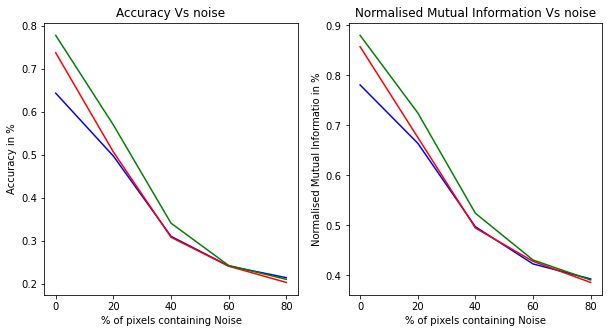

In [82]:
import matplotlib.pyplot as plt

noise_levels = np.arange(0, 1, 0.2)
noise_levels_mod = (noise_levels * 100).tolist()
print(noise_levels_mod)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(noise_levels_mod, acc_nmf_mean, color='blue')
axes[0].plot(noise_levels_mod, acc_L2_mean, color='red')
axes[0].plot(noise_levels_mod, acc_hyper_mean, color='green')
axes[1].plot(noise_levels_mod, nmi_nmf_mean, color='blue')
axes[1].plot(noise_levels_mod, nmi_L2_mean, color='red')
axes[1].plot(noise_levels_mod, nmi_hyper_mean, color='green')

axes[0].set_xlabel("% of pixels containing Noise")
axes[0].set_ylabel("Accuracy in %")
axes[0].set_title("Accuracy Vs noise")
axes[1].set_xlabel("% of pixels containing Noise")
axes[1].set_ylabel("Normalised Mutual Informatio in %")
axes[1].set_title("Normalised Mutual Information Vs noise")
plt.show()